# Baseline Signature-Score Classifier

This notebook implements a baseline signature-score classifier to predict tissue of origin based on single-cell gene expression data. The process follows these steps:

1.  **Setup and Data Loading**: Recreate the annotated `AnnData` object from the previous notebook, including QC, normalization, and tissue annotation.
2.  **Marker Gene Selection**: Select a list of high-quality marker genes for each tissue based on differential expression statistics.
3.  **Signature Scoring**: Build a scoring model where each cell gets a score for each tissue's signature.
4.  **Prediction**: Classify each cell based on the highest tissue score, with a guard for uncertainty.
5.  **Evaluation**: Split the data by donor, train the model, and evaluate its accuracy on a test set.

In [ ]:
# Install required libraries
%pip install matplotlib seaborn scanpy scikit-learn plotly ipywidgets requests GEOparse scikit-misc leidenalg python-igraph

In [16]:
# --- 1. Setup and Imports ---
import os
import tarfile
import shutil
import gzip
import zipfile
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
sc.settings.verbosity = 1  # Reduce scanpy output

## 2. Load and Prepare Data

This section consolidates the data loading and preprocessing steps from the previous notebook. It finds the 10x genomics data, loads it into an `AnnData` object, performs QC filtering, normalization, clustering, and annotates each cell with its tissue of origin.

In [17]:
# --- Data Loading and Preprocessing ---

# Define paths
OUTDIR = Path('./GSE182158_out')
WORK_ROOT = OUTDIR / 'raw_expanded'
WORK_ROOT.mkdir(exist_ok=True, parents=True)

# Helper function to verify 10x directories
def verify_10x_dir(dir_path: Path) -> bool:
    if not dir_path.is_dir(): return False
    files = {f.name for f in dir_path.iterdir() if f.is_file()}
    return (any(f.startswith('matrix.mtx') for f in files) and
            any(f.startswith('barcodes.tsv') for f in files) and
            any(f.startswith('features.tsv') for f in files))

# Find valid 10x directories
repacked_dirs = list(WORK_ROOT.glob('*_repacked'))
valid_dirs = [d for d in repacked_dirs if d.is_dir() and verify_10x_dir(d)]
print(f"Found {len(valid_dirs)} pre-processed 10x directories.")

# Load data
adatas_list = []
sample_names_list = []
for path in tqdm(valid_dirs, desc="Loading 10x data"):
    sample_name = path.name.replace('_repacked', '')
    adata_sample = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
    adatas_list.append(adata_sample)
    sample_names_list.append(sample_name)

# Combine into a single AnnData object
if adatas_list:
    adata = ad.concat(adatas_list, label="sample", index_unique="-")
    print(f"Combined AnnData object created: {adata.n_obs} cells, {adata.n_vars} genes.")
else:
    raise FileNotFoundError("No data loaded. Ensure the 'GSE182158_out/raw_expanded' directory is populated from the previous notebook.")

# --- QC, Filtering, and Annotation ---
adata.var_names_make_unique()
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
adata.layers['counts'] = adata.X.copy()

# Filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=500)
adata = adata[adata.obs.pct_counts_mt < 10.0, :]
sc.pp.filter_genes(adata, min_cells=3)
print(f"After filtering: {adata.n_obs} cells, {adata.n_vars} genes.")

# Normalization and Preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3', subset=True)

# Dimensionality Reduction and Clustering
sc.tl.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
sc.tl.leiden(adata, resolution=0.6, key_added="leiden_clusters")

# Tissue Annotation
int_to_code = {
  "0": "D01", "1": "D02", "2": "D03",
  "3": "B01", "4": "B02", "5": "B03",
  "6": "U01", "7": "U02",
  "8": "A01", "9": "A02", "10": "A03",
}
adata.obs['sample_code'] = adata.obs['sample'].astype(str).map(int_to_code)
adata.obs['tissue_letter'] = adata.obs['sample_code'].str[0]
tissue_map = {'A': 'Adipose', 'B': 'Bone marrow', 'D': 'Dermis', 'U': 'Umbilical'}
adata.obs['tissue_name'] = adata.obs['tissue_letter'].map(tissue_map).astype('category')

print("Data preparation complete.")
print("Tissue counts:\n", adata.obs['tissue_name'].value_counts())

Found 11 pre-processed 10x directories.


Loading 10x data: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]



Combined AnnData object created: 146426 cells, 33694 genes.
After filtering: 142064 cells, 29760 genes.
After filtering: 142064 cells, 29760 genes.
Data preparation complete.
Tissue counts:
 tissue_name
Bone marrow    45081
Adipose        39223
Dermis         30909
Umbilical      26851
Name: count, dtype: int64
Data preparation complete.
Tissue counts:
 tissue_name
Bone marrow    45081
Adipose        39223
Dermis         30909
Umbilical      26851
Name: count, dtype: int64


## 3. Tissue Marker Gene Analysis

We first run the differential expression analysis to find marker genes for each tissue. The results are saved to a CSV file and will be used to build our classifier. > ((THIS PART IS REMOVED, BECAUSE IT WAS LEADING TO "data leakage"))

## 4. Baseline Signature-Score Classifier

Here we build and evaluate the classifier based on the user's specifications.

... storing 'sample_code' as categorical
... storing 'tissue_letter' as categorical
... storing 'tissue_letter' as categorical


Data split: 94342 training cells, 47722 testing cells.
Selected marker genes per tissue (after de-duplication):
  - Adipose: 10 genes
  - Bone marrow: 10 genes
  - Dermis: 10 genes
  - Umbilical: 10 genes
Selected marker genes per tissue (after de-duplication):
  - Adipose: 10 genes
  - Bone marrow: 10 genes
  - Dermis: 10 genes
  - Umbilical: 10 genes

Classification Accuracy (on non-Unknown): 60.52%
Number of 'Unknown' predictions: 8619

Classification Accuracy (on non-Unknown): 60.52%
Number of 'Unknown' predictions: 8619


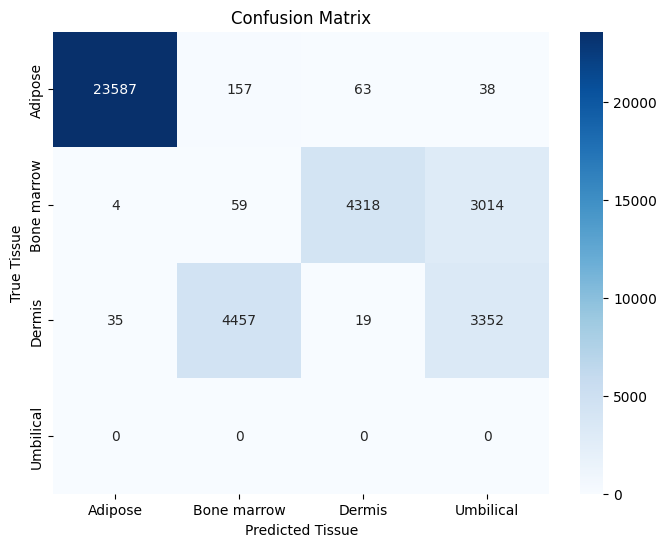

In [18]:
# --- 1. Train/Test Split by Donor ---
donor_ids = adata.obs['sample_code'].unique()
train_donors, test_donors = train_test_split(donor_ids, test_size=0.3, random_state=42)

train_idx = adata.obs[adata.obs['sample_code'].isin(train_donors)].index
test_idx = adata.obs[adata.obs['sample_code'].isin(test_donors)].index

adata_train = adata[train_idx, :].copy()
adata_test = adata[test_idx, :].copy()

print(f"Data split: {len(train_idx)} training cells, {len(test_idx)} testing cells.")

# --- 2. Find Marker Genes (using training data ONLY) ---
sc.tl.rank_genes_groups(adata_train, 'tissue_name', method='wilcoxon', key_added='rank_genes_groups_tissue')

# --- Extract Top Markers from Training Data ---
marker_results_tissue = adata_train.uns['rank_genes_groups_tissue']
groups_tissue = marker_results_tissue['names'].dtype.names
de_results = pd.DataFrame()

for group in groups_tissue:
    markers = sc.get.rank_genes_groups_df(adata_train, group=group, key='rank_genes_groups_tissue')
    markers['tissue'] = group
    de_results = pd.concat([de_results, markers], ignore_index=True)

# --- 3. Inputs & Setup ---
tissues = adata_train.obs['tissue_name'].cat.categories.tolist()
N_TOP_GENES = 10
MIN_GENES_PRESENT = 5
UNCERTAINTY_MARGIN = 0.3

# --- 4. Select Marker Genes (per tissue) ---
selected_markers = {}
# Filter based on thresholds
filtered_de = de_results[
    (de_results['pvals_adj'] <= 0.05) &
    (de_results['logfoldchanges'] >= .25)
].copy()

for tissue in tissues:
    # Sort by score and take top N
    markers = filtered_de[filtered_de['tissue'] == tissue].sort_values('scores', ascending=False)
    top_n = markers.head(N_TOP_GENES)
    # Keep only genes present in the final adata object
    genes = [g for g in top_n['names'] if g in adata_train.var_names]
    selected_markers[tissue] = pd.DataFrame({
        'gene': genes,
        'log2FC': [top_n[top_n['names'] == g]['logfoldchanges'].iloc[0] for g in genes]
    })

# De-duplicate genes, keeping the one with the highest log2FC
all_selected = pd.concat(selected_markers.values())
all_selected = all_selected.sort_values('log2FC', ascending=False).drop_duplicates('gene', keep='first')

final_markers = {}
for tissue in tissues:
    tissue_markers = selected_markers[tissue]
    final_markers[tissue] = tissue_markers[tissue_markers['gene'].isin(all_selected['gene'])].set_index('gene')

print("Selected marker genes per tissue (after de-duplication):")
for tissue, markers in final_markers.items():
    print(f"  - {tissue}: {len(markers)} genes")

# --- 5. Per-gene Scaling (using training data) ---
marker_gene_list = all_selected['gene'].unique().tolist()
X_train_markers = adata_train[:, marker_gene_list].X.toarray()

median_vals = np.median(X_train_markers, axis=0)
mad_vals = np.median(np.abs(X_train_markers - median_vals), axis=0)
epsilon = 1e-8
mad_vals[mad_vals < epsilon] = np.std(X_train_markers[:, mad_vals < epsilon], axis=0) # Fallback to SD

# --- 6. Signature Scores & Prediction (on test data) ---
X_test_markers = adata_test[:, marker_gene_list].X.toarray()
Z_test = (X_test_markers - median_vals) / (mad_vals + epsilon)
Z_test_df = pd.DataFrame(Z_test, index=adata_test.obs_names, columns=marker_gene_list)

scores_df = pd.DataFrame(index=adata_test.obs_names)
for tissue in tissues:
    markers = final_markers[tissue]
    weights = markers['log2FC'].clip(lower=0, upper=3.0)
    
    # Align Z-scores with the tissue's markers and weights
    z_subset = Z_test_df[markers.index]
    
    # Calculate weighted mean score
    scores_df[tissue] = (z_subset * weights).sum(axis=1) / weights.sum()

# --- 7. Prediction Rule ---
predictions = []
for idx, row in scores_df.iterrows():
    sorted_scores = row.sort_values(ascending=False)
    top1_tissue = sorted_scores.index[0]
    top1_score = sorted_scores.iloc[0]
    top2_score = sorted_scores.iloc[1]
    
    if (top1_score - top2_score) < UNCERTAINTY_MARGIN:
        predictions.append("Unknown")
    else:
        predictions.append(top1_tissue)

adata_test.obs['predicted_tissue'] = predictions

# --- 8. Evaluation ---
true_labels = adata_test.obs['tissue_name']
# Filter out 'Unknown' predictions for accuracy calculation
eval_idx = adata_test.obs['predicted_tissue'] != "Unknown"
accuracy = accuracy_score(true_labels[eval_idx], adata_test.obs['predicted_tissue'][eval_idx])
print(f"\nClassification Accuracy (on non-Unknown): {accuracy:.2%}")
print(f"Number of 'Unknown' predictions: {np.sum(adata_test.obs['predicted_tissue'] == 'Unknown')}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels[eval_idx], adata_test.obs['predicted_tissue'][eval_idx], labels=tissues)
conf_df = pd.DataFrame(conf_matrix, index=tissues, columns=tissues)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Tissue')
plt.ylabel('True Tissue')
plt.show()


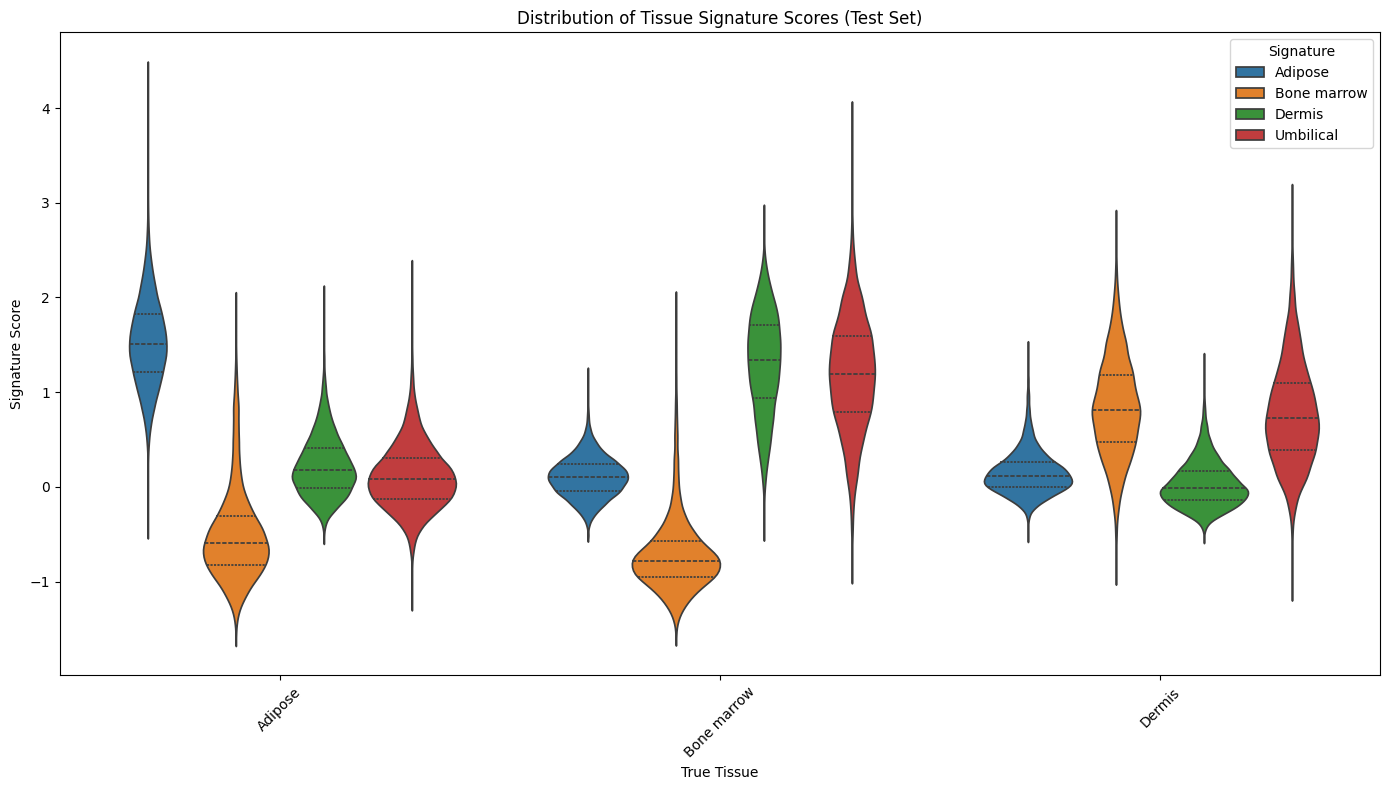

In [19]:
# Add true tissue labels to the scores dataframe for plotting
scores_df['true_tissue'] = adata_test.obs['tissue_name']

# Melt the dataframe for easy plotting with seaborn
scores_melted = scores_df.melt(
    id_vars=['true_tissue'],
    value_vars=tissues,
    var_name='signature',
    value_name='score'
)

# Create violin plots
plt.figure(figsize=(14, 8))
sns.violinplot(data=scores_melted, x='true_tissue', y='score', hue='signature', inner='quartile')
plt.title('Distribution of Tissue Signature Scores (Test Set)')
plt.xlabel('True Tissue')
plt.ylabel('Signature Score')
plt.xticks(rotation=45)
plt.legend(title='Signature')
plt.tight_layout()
plt.show()


## 5. Classification using CellTypist

As an alternative to our custom signature-score model, we can use `CellTypist`, a powerful, pre-packaged classification tool. It uses a logistic regression model under the hood but is highly optimized for single-cell data.

We will train it on our training donors and evaluate its performance on the test donors, just like before.


In [ ]:

# Install CellTypist
%pip install celltypist


🍳 Preparing data before training
✂️ 18 non-expressed genes are filtered out
🔬 Input data has 94342 cells and 2982 genes
⚖️ Scaling input data
✂️ 18 non-expressed genes are filtered out
🔬 Input data has 94342 cells and 2982 genes
⚖️ Scaling input data
🏋️ Training data using SGD logistic regression
🏋️ Training data using SGD logistic regression
🔎 Selecting features
🧬 697 features are selected
🏋️ Starting the second round of training
🔎 Selecting features
🧬 697 features are selected
🏋️ Starting the second round of training
🏋️ Training data using SGD logistic regression
🏋️ Training data using SGD logistic regression
✅ Model training done!
🔬 Input data has 47722 cells and 3000 genes
✅ Model training done!
🔬 Input data has 47722 cells and 3000 genes
🔗 Matching reference genes in the model
🧬 697 features used for prediction
⚖️ Scaling input data
🔗 Matching reference genes in the model
🧬 697 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
🖋️ Predicting labels
✅ Predictio

CellTypist Classification Accuracy (on non-Unknown): 57.03%
Number of 'Unknown' predictions: 21211


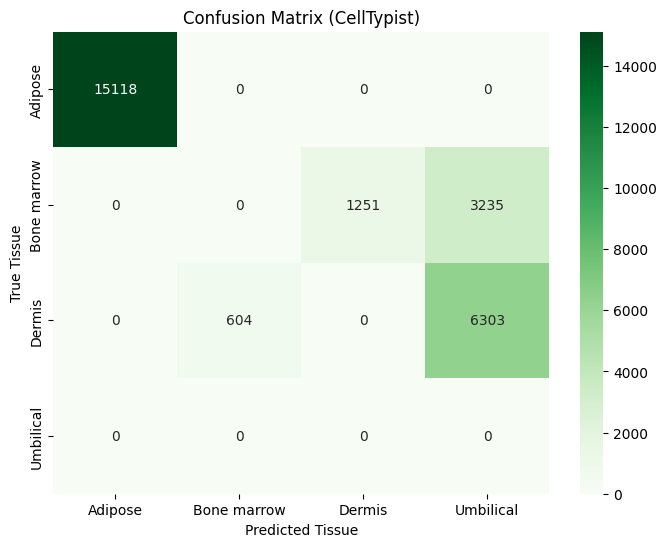

In [21]:
# --- Train and Run CellTypist Classifier ---
import celltypist as ct
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import logging
import numpy as np

# --- Setup Logging ---
# Create a logger
logger = logging.getLogger('classifier_logger')
logger.setLevel(logging.INFO)
# Create a file handler and set the format
if not logger.handlers:
    file_handler = logging.FileHandler('classifier_accuracy.log', mode='a')
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

# --- Refine over-clustering for prediction ---
# A higher resolution can lead to more granular clusters for majority voting
sc.tl.leiden(adata_test, resolution=1.0, key_added='leiden_clusters_hires')

# Ensure data is properly normalized for CellTypist
for A in (adata_train, adata_test):
    if "log1p_norm_1e4_done" not in A.uns:
        sc.pp.normalize_total(A, target_sum=1e4)
        sc.pp.log1p(A)
        A.uns["log1p_norm_1e4_done"] = True

# 1. Train a custom model with improved parameters
model = ct.train(
    adata_train, 
    labels="tissue_name", 
    # Use only highly variable genes for training
    feature_selection=True,
    use_SGD=True, 
    alpha=1e-4,        # Adjust regularization
    max_iter=1000,     # Increase iterations to ensure convergence
    n_jobs=-1, 
    check_expression=True
)

# 2. Predict on the test data with majority voting
# Use the new high-resolution clusters for over-clustering
predictions = ct.annotate(adata_test, model=model, majority_voting=True, over_clustering='leiden_clusters_hires')

# 3. Add predictions to the AnnData object
# Extract the predicted labels correctly - handle both Series and DataFrame cases
if hasattr(predictions.predicted_labels, 'iloc'):
    # If it's a DataFrame, get the first column or the 'predicted_labels' column
    if 'predicted_labels' in predictions.predicted_labels.columns:
        predicted_labels_series = predictions.predicted_labels['predicted_labels']
    else:
        predicted_labels_series = predictions.predicted_labels.iloc[:, 0]
else:
    # If it's already a Series
    predicted_labels_series = predictions.predicted_labels

adata_test.obs["predicted_tissue_celltypist"] = predicted_labels_series
# Use probability_matrix for thresholding
adata_test.obs["prediction_probability"] = predictions.probability_matrix.max(axis=1)

# Add "Unknown" to the categories before assigning it
if "Unknown" not in adata_test.obs["predicted_tissue_celltypist"].cat.categories:
    adata_test.obs["predicted_tissue_celltypist"] = adata_test.obs["predicted_tissue_celltypist"].cat.add_categories(["Unknown"])

# 4. Apply an uncertainty threshold
PROBABILITY_THRESHOLD = 0.5  # Use a more standard threshold
adata_test.obs.loc[adata_test.obs["prediction_probability"] < PROBABILITY_THRESHOLD, "predicted_tissue_celltypist"] = "Unknown"

# 5. Evaluate the results
true_labels_ct = adata_test.obs['tissue_name']
predicted_labels_ct = adata_test.obs['predicted_tissue_celltypist']

# Filter out 'Unknown' predictions for accuracy calculation
eval_idx_ct = predicted_labels_ct != "Unknown"
accuracy_ct = accuracy_score(true_labels_ct[eval_idx_ct], predicted_labels_ct[eval_idx_ct])
unknown_count = np.sum(predicted_labels_ct == 'Unknown')

print(f"CellTypist Classification Accuracy (on non-Unknown): {accuracy_ct:.2%}")
print(f"Number of 'Unknown' predictions: {unknown_count}")

# Log the results
logger.info(f"CellTypist Accuracy: {accuracy_ct:.2%}, Unknown Predictions: {unknown_count}")


# 6. Confusion Matrix
conf_matrix_ct = confusion_matrix(true_labels_ct[eval_idx_ct], predicted_labels_ct[eval_idx_ct], labels=tissues)
conf_df_ct = pd.DataFrame(conf_matrix_ct, index=tissues, columns=tissues)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_df_ct, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (CellTypist)')
plt.xlabel('Predicted Tissue')
plt.ylabel('True Tissue')
plt.show()
